# Demo: Applying Quality Control.
In this example, we apply Quality Control (QC) on the demo data. 

## Create your dataset
We start by creating a dataset.

In [1]:
import metobs_toolkit
your_dataset = metobs_toolkit.Dataset()
your_dataset.update_file_paths(
    input_data_file=metobs_toolkit.demo_datafile, # path to the data file
    input_metadata_file=metobs_toolkit.demo_metadatafile,
    template_file=metobs_toolkit.demo_template,
)

your_dataset.import_data_from_file()

The following data columns are renamed because of special meaning by the toolkit: {}
Luchtdruk is present in the datafile, but not found in the template! This column will be ignored.
Neerslagintensiteit is present in the datafile, but not found in the template! This column will be ignored.
Neerslagsom is present in the datafile, but not found in the template! This column will be ignored.
Rukwind is present in the datafile, but not found in the template! This column will be ignored.
Luchtdruk_Zeeniveau is present in the datafile, but not found in the template! This column will be ignored.
Globe Temperatuur is present in the datafile, but not found in the template! This column will be ignored.
The following metadata columns are renamed because of special meaning by the toolkit: {}
These stations will be removed because of only having one record: []


A number of quality control methods are available in the toolkit. We can classify them into two groups:

1. **Quality control for missing/duplicated or invalid timestamps**. This is applied to the raw data and is not based on the observational value but merely on the presence of a record. 
2. **Quality control for bad observations**. These are not automatically executed. These checks are performed in a sequence of specific checks, that are looking for signatures of typically bad observations.

## Quality control for missing/duplicated and invalid timestamps
Since this is applied to the raw data, the following quality control checks are automatically performed when reading the data:

* Nan check: Test if the value of an observation can be converted to a numeric value.
* Gap finder: Test if there are missing records. These are stored as `metobs_toolkit.Gap()`.
* Duplicate check: Test if each observation (station name, timestamp, observation type) is unique.

As an example, you can see that there is a missing timestamp (=gap) in the time series of some stations:

/home/thoverga/Documents/VLINDER_github/MetObs_toolkit/metobs_toolkit/dataset_core.py:503: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combdf = pd.concat([df, outliersdf])  # combine the two


<Axes: title={'center': 'Temperatuur of vlinder02'}, xlabel='datetime', ylabel='temp (Celsius)'>

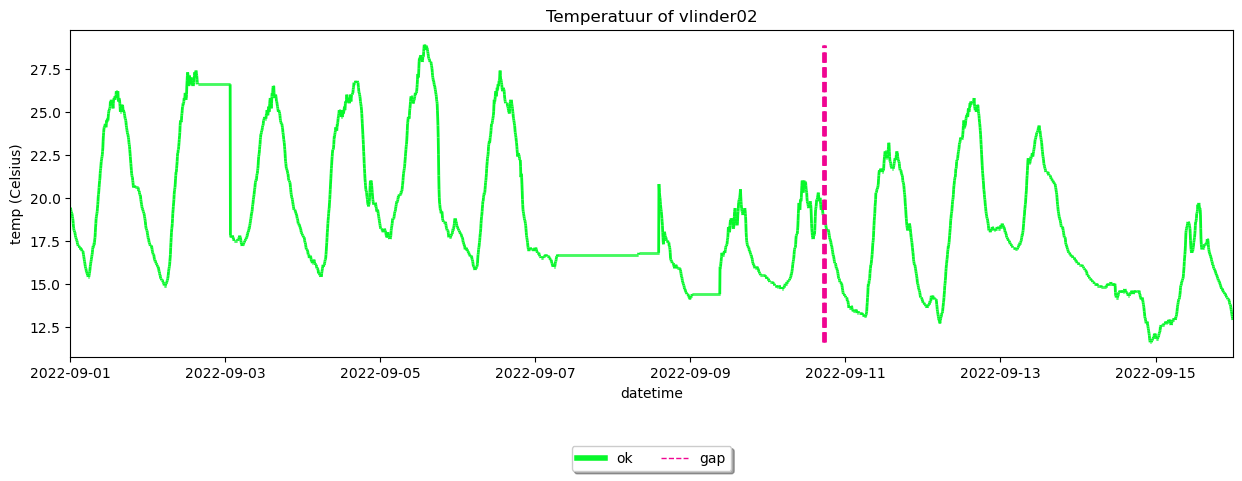

In [2]:
your_dataset.get_station('vlinder02').make_plot(colorby='label')


## Quality control for bad observations
The following checks are available:

* *Gross value check*: A threshold check that observations should be between the thresholds
* *Persistence check*: Test observations to change over a specific period.
* *Repetitions check*: Test if an observation changes after several records.
* *Spike check*: Test if observations do not produce spikes in time series.
* *Window variation check*: Test if the variation exceeds the threshold in moving time windows.
* *Toolkit Buddy check*: Spatial buddy check.
* *TITAN Buddy check*: The [Titanlib version of the buddy check](https://github.com/metno/titanlib/wiki/Buddy-check).
* *TITAN Spatial consistency test*: Apply the Titanlib (robust) [Spatial-Consistency-Test](https://github.com/metno/titanlib/wiki/Spatial-consistency-test-resistant) (SCT).

Each check requires a set of specific settings, often stored per specific observation type. A set of default settings, for temperature observations, are stored in the settings of each dataset. Use the *get_info()* method, and scroll to the QC section to see all QC settings.


In [3]:
your_dataset.settings.get_info()

All settings:
 
 ---------------------------------------

 ---------------- IO (settings) ----------------------

* output_folder: 

  -None 

* input_data_file: 

  -/home/thoverga/Documents/VLINDER_github/MetObs_toolkit/metobs_toolkit/datafiles/demo_datafile.csv 

* input_metadata_file: 

  -/home/thoverga/Documents/VLINDER_github/MetObs_toolkit/metobs_toolkit/datafiles/demo_metadatafile.csv 

 ---------------- app (settings) ----------------------

* print_fmt_datetime: 

  -%d/%m/%Y %H:%M:%S 

* print_max_n: 

  -40 

* plot_settings: 

  - time_series: 

    -{'figsize': (15, 5), 'colormap': 'tab20', 'linewidth': 2, 'linestyle_ok': '-', 'linestyle_fill': '--', 'scattersize': 4, 'scatterzorder': 3, 'dashedzorder': 2, 'legend_n_columns': 5} 

  - spatial_geo: 

    -{'extent': [2.260609, 49.25, 6.118359, 52.350618], 'cmap': 'inferno_r', 'n_for_categorical': 5, 'figsize': (10, 15), 'fmt': '%d/%m/%Y %H:%M:%S UTC'} 

  - pie_charts: 

    -{'figsize': (10, 10), 'anchor_legend_big': (-0

Use the ``update_qc_settings()`` method to update the default settings.

In [4]:
your_dataset.update_qc_settings(obstype='temp',
                                gross_value_max_value=26.3,
                                persis_time_win_to_check='30min' #30 minutes
                                )

To apply the quality control on the full dataset use the ``apply_quality_control()`` method. Spatial quality control checks can be applied by using the ``apply_buddy_check()``, ``apply_titan_buddy_check()`` and ``apply_titan_sct_resistant_check()`` methods.

In [5]:
your_dataset.apply_quality_control(
        obstype="temp",  # which observations to check
        gross_value=True,  # apply gross_value check?
        persistence=True,  # apply persistence check?
        step=True,  # apply the step check?
        window_variation=True,  # apply internal consistency check?
    )

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f70ba0c52d0>>
Traceback (most recent call last):
  File "/home/thoverga/anaconda3/envs/metobs_dev/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


Use the dataset.show() or the time series plot methods to see the effect of the quality control.

<Axes: title={'center': 'Temperatuur for all stations. '}, xlabel='datetime', ylabel='temp (Celsius)'>

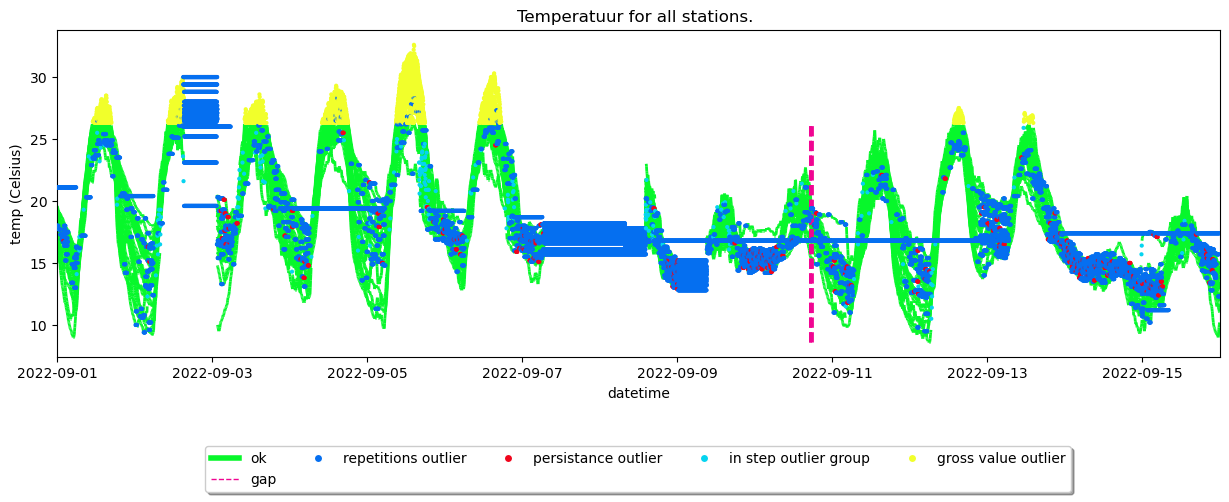

In [6]:
your_dataset.make_plot(obstype='temp', colorby='label')

If you are interested in the performance of the applied QC, you can use the ``get_qc_stats()`` method to get an overview of the frequency statistics.

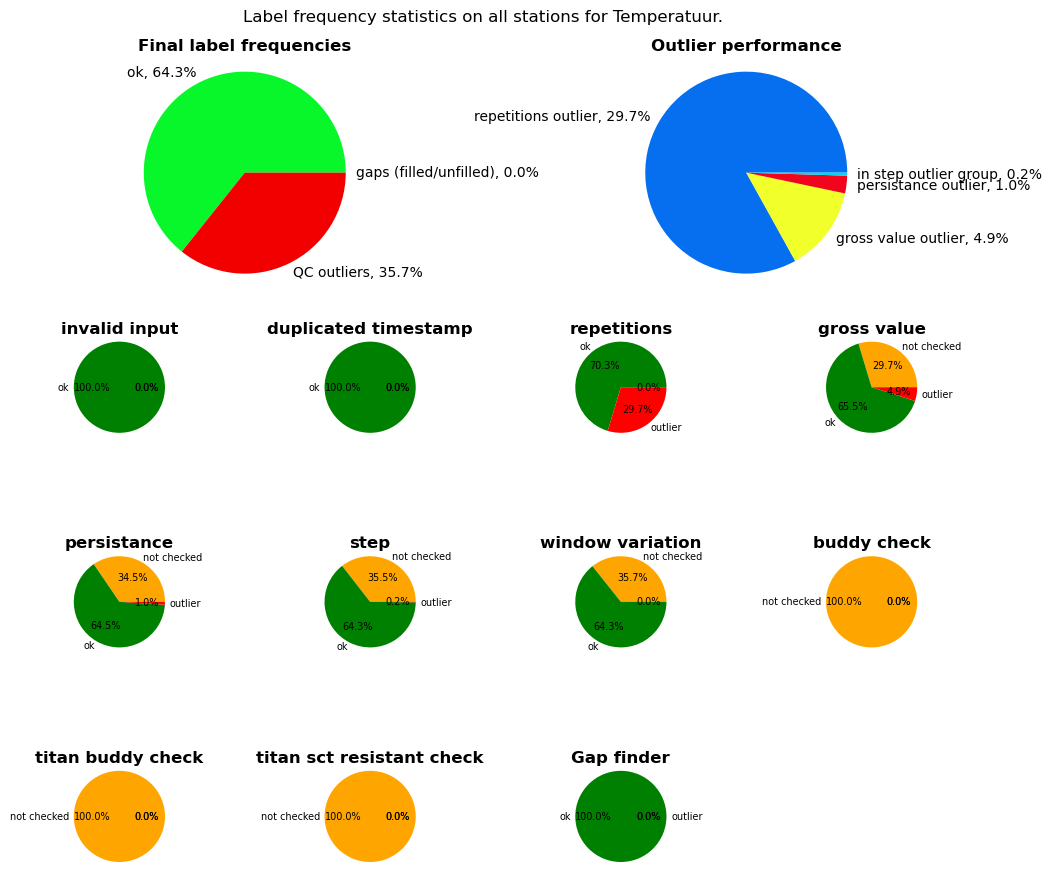

({'ok': 64.28984788359789,
  'QC outliers': 35.707671957671955,
  'gaps (filled/unfilled)': 0.00248015873015873},
 {'repetitions outlier': 29.658564814814813,
  'gross value outlier': 4.869378306878307,
  'persistance outlier': 1.0085978835978835,
  'in step outlier group': 0.17113095238095238,
  'in window variation outlier group': 0.0,
  'invalid input': 0.0,
  'buddy check outlier': 0.0,
  'titan buddy check outlier': 0.0,
  'sct resistant check outlier': 0.0,
  'duplicated timestamp outlier': 0.0},
 {'invalid_input': {'not checked': 0.0, 'ok': 100.0, 'outlier': 0.0},
  'duplicated_timestamp': {'not checked': 0.0, 'ok': 100.0, 'outlier': 0.0},
  'repetitions': {'not checked': 0.0,
   'ok': 70.34143518518519,
   'outlier': 29.658564814814813},
  'gross_value': {'not checked': 29.658564814814813,
   'ok': 65.47205687830689,
   'outlier': 4.869378306878307},
  'persistance': {'not checked': 34.52794312169312,
   'ok': 64.46345899470899,
   'outlier': 1.0085978835978835},
  'step': {'no

In [7]:
your_dataset.get_qc_stats(obstype='temp', make_plot=True)